In [1]:
from tqdm import tqdm
from time import time
from tqdm import trange

import matplotlib.pyplot as plt

import numpy as np
import scipy

import jax
jax.config.update("jax_enable_x64", True)

import jax.flatten_util as flatten_util
import jax.numpy as jnp


from flax import linen as nn


In [3]:
seed = 0

In [4]:
class ResNet(nn.Module):
    """A simple ResNet model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=500)(jnp.sin(2 * jnp.pi * x))
        x = nn.tanh(x)

        y = nn.Dense(features=500)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=500)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=500)(x)
        x = x + nn.tanh(y)

        x = nn.Dense(features=1)(x)
        return x


model_fn = ResNet()

In [5]:
def scalar_model_fn(params, batch):
    return model_fn.apply(params, batch)[0]


model_grad = jax.value_and_grad(scalar_model_fn, argnums=0)


def raveled_grad_fn(params, batch):
    value, grad = model_grad(params, batch)
    return value, flatten_util.ravel_pytree(grad)[0]


jacobian_fn = jax.jit(jax.vmap(raveled_grad_fn, in_axes=(None, 0), out_axes=(0, 0)))

In [6]:
# Target function = linear combination of Chebyshev polynomials
key = jax.random.PRNGKey(seed)
ord = 30

coeff = jax.random.normal(key, shape=(ord,))
poly = np.polynomial.chebyshev.Chebyshev(coeff)

def target_fn(x):
    return poly(jnp.sin(2 * jnp.pi * x)) / np.sqrt(ord)

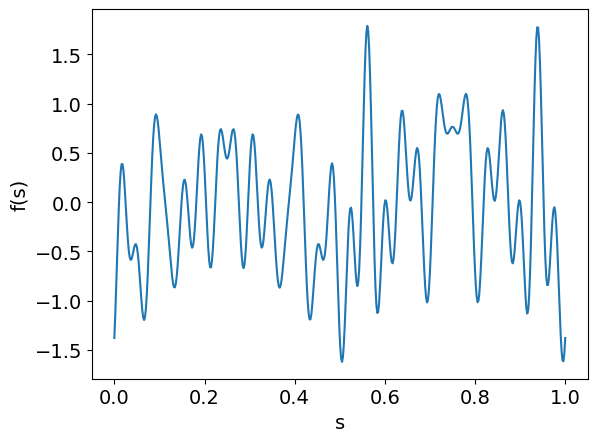

In [7]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

xs = np.linspace(0,1,500)
plt.plot(xs, target_fn(xs))
plt.xlabel("s")
plt.ylabel("f(s)")
plt.savefig("NN_target_fn.pdf", bbox_inches='tight')

In [8]:
def loss_fn(model_params, xs):
    """Mean-squared error loss"""
    predictions = model_fn.apply(model_params, xs)
    targets = target_fn(xs)

    return jnp.mean((predictions - targets) ** 2)


loss_fn = jax.jit(loss_fn)
loss_fn_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=0))

In [9]:
rng = jax.random.PRNGKey(seed)

rng, key = jax.random.split(rng)
dummy_x = jax.random.uniform(key, shape=(100, 1))

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
param_vec, unravel_fn = flatten_util.ravel_pytree(params)

initial_params = params

print(f"nparams: {jax.flatten_util.ravel_pytree(params)[0].shape[0]}")

nparams: 753001



# Optimizer

In [10]:
def get_NGD_optimizer(params, rng, dummy_x, eta, lamb):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    opt_state = []

    def step(params, batch, targets, opt_state, rng):
        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        residuals = (targets - predictions)

        loss = jnp.sum(residuals**2) / batch_size

        jacobian /= jnp.sqrt(batch_size)
        residuals /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)

        ravel_update = jacobian.T @ jax.scipy.linalg.solve(T, residuals, assume_a="pos")

        update = unravel_fn(ravel_update)
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)

        return params, [], rng, loss, None

    return opt_state, jax.jit(step), rng



# Run optimization loop

In [11]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2
eta = 0.5
num_it = 3000

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_NGD_optimizer(params, rng, dummy_x, eta, lamb)

batch_size = 500

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

Loss 4.818e-07: 100%|██████████| 3000/3000 [01:59<00:00, 25.17its/s]


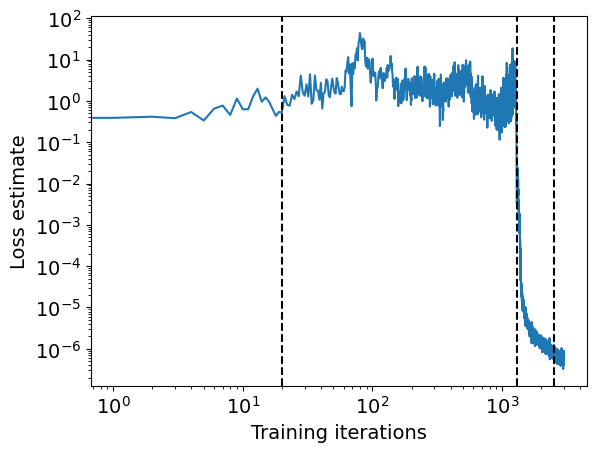

In [12]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
plt.axvline(start_it, color='black', linestyle='--')
plt.axvline(mid_it, color='black', linestyle='--')
plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

plt.savefig(f"NN_training.pdf", bbox_inches='tight')

# Test least-squares solvers

In [13]:
def get_rbk_step():
    def rbk_step(x, AS, bS):
        Q,R = jnp.linalg.qr(AS.T)
        return x + Q @ jnp.linalg.solve(R.T, bS - AS @ x)

    return jax.jit(rbk_step)

def get_reblock_step(lamb=0.001):
    def reblock_step(x, AS, bS):
        k = AS.shape[0]
        T = AS @ AS.T + lamb * k * np.eye(k)
        return x + AS.T @ jax.scipy.linalg.solve(T, bS - AS @ x, assume_a='pos')

    return jax.jit(reblock_step)


def get_minibatch_sgd_step(eta=0.01):
    def minibatch_sgd_step(x, AS, bS):
        k = AS.shape[0]
        return x + eta * AS.T @ (bS - AS @ x) / k

    return jax.jit(minibatch_sgd_step)

In [14]:
def block_kaczmarz(params, k, total_time, burn_time, take_step):
    rng = jax.random.PRNGKey(seed)

    n = flatten_util.ravel_pytree(params)[0].shape[0]
    x_kaczmarz = jnp.zeros(n)
    x_out = jnp.zeros(n)

    ts = []
    errs = []

    def run_iteration(x_kaczmarz, S, targets, rng):
        fthetaS, JS = jacobian_fn(params, S)
        rS = targets - fthetaS

        return take_step(x_kaczmarz, JS, rS), JS, rS, rng

    run_iteration = jax.jit(run_iteration)

    x_sum = jnp.zeros_like(x_kaczmarz)

    start_t = time()
    curr_t = start_t
    it = 1
    Tburn = jnp.inf

    pbar = tqdm(total=total_time * 1000, position=0, leave=True)

    while (curr_t - start_t) < total_time:
        rng, key = jax.random.split(rng)
        S = jax.random.uniform(key, shape=(k, 1))

        targets = target_fn(S[:,0])
        x_kaczmarz, JS, rS, rng = run_iteration(x_kaczmarz, S, targets, rng)

        # Throw out 5 iterations because otherwise jax compilation time will throw things off
        if it > 5:
            loss_estimate = jnp.mean((JS @ x_out - rS)**2) / jnp.mean(rS**2)

            new_curr_t = time()
            pbar.update(int(1000 * (new_curr_t - curr_t)))
            pbar.set_description(f"Loss: {loss_estimate:.2e}")
            curr_t = new_curr_t

            ts.append(curr_t - start_t)
            errs.append(loss_estimate)

            if curr_t > start_t + burn_time and Tburn == jnp.inf:
              Tburn = it
            if it > Tburn:
              x_sum += x_kaczmarz
              x_out = x_sum / (it - Tburn)
            else:
              x_out = x_kaczmarz



        if it == 5:
            start_t = time()

        it += 1

    return ts, errs, Tburn

In [15]:
k = 50
lamb = 0.001
total_time, burn_time = 100, 1

In [16]:
nhalf = 5
nwindow = 2 * nhalf + 1

def get_es(es):
    window = np.ones(nwindow) / nwindow
    return np.convolve(es, window, 'valid')

def get_ts(ts):
    relative_ts = [t - ts[0] for t in ts]
    return relative_ts[nhalf:-nhalf]

# Start it, k=50

In [84]:
params = start_params
t_sgd, e_sgd, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_minibatch_sgd_step(eta=2e-4))

Loss: 2.21e-01:  92%|█████████▏| 91667/100000 [01:40<00:09, 911.11it/s]


In [85]:
params = start_params
t_reblock, e_reblock, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 6.70e-02:  92%|█████████▏| 92112/100000 [01:40<00:08, 914.71it/s]


In [86]:
params = start_params
t_rbk, e_rbk, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_rbk_step())

Loss: 2.82e+14: : 100735it [01:41, 993.54it/s]


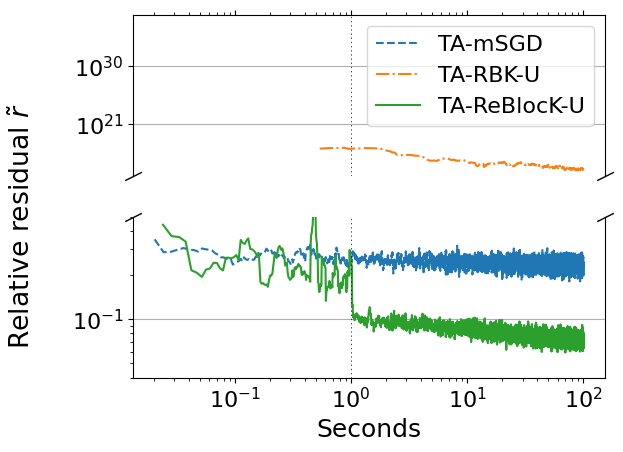

In [93]:
# See https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.3)  # adjust space between Axes

# Plot the same data on both Axes
ax1.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
ax1.plot(get_ts(t_rbk), get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
ax1.plot(get_ts(t_reblock), get_es(e_reblock), label='TA-ReBlocK-U')
ax1.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(1e13, 1e38)  # RBK
ax1.grid(axis='y')


ax2.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
ax2.plot(get_ts(t_rbk), get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
ax2.plot(get_ts(t_reblock), get_es(e_reblock), label='TA-ReBlocK-U')
ax2.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(0.04, 0.5)  # mSGD, ReBlocK
ax2.grid(axis='y')

ax1.legend(loc='upper right')

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Seconds")
fig.supylabel(r"Relative residual $\tilde{r}$")
plt.tight_layout()

plt.savefig("NN_start.pdf", bbox_inches='tight')

In [88]:
sgd_per_second = len(e_sgd) / 100
reblock_per_second = len(e_reblock) / 100
rbk_per_second = len(e_rbk) / 100
print(sgd_per_second, reblock_per_second, rbk_per_second)

242.1 227.87 9.28


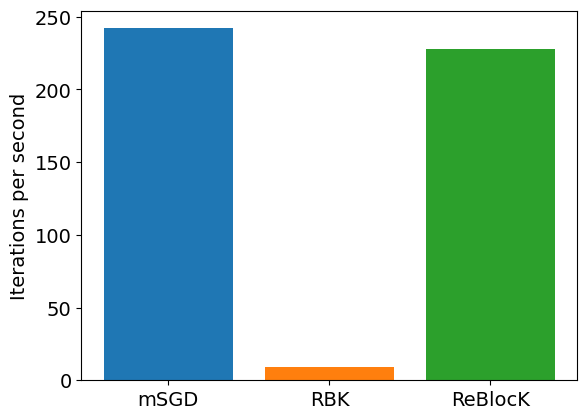

In [89]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

fig, ax = plt.subplots()
ax.bar("mSGD", sgd_per_second)
ax.bar("RBK",  rbk_per_second)
ax.bar("ReBlocK", reblock_per_second)
ax.set_ylabel("Iterations per second")
plt.savefig(f"it_speed.pdf", dpi=400, bbox_inches='tight')

# Mid it k=50

In [159]:
params = mid_params
t_sgd, e_sgd, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_minibatch_sgd_step(eta=1e-4))

Loss: 5.13e-01:  92%|█████████▏| 91724/100000 [01:40<00:09, 911.04it/s]


In [160]:
params = mid_params
t_reblock, e_reblock, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 2.63e-04:  90%|█████████ | 90447/100000 [01:40<00:10, 898.24it/s]


In [161]:
params = mid_params
t_rbk, e_rbk, Tburn = block_kaczmarz(params, k, 20 * total_time, burn_time, get_rbk_step())

Loss: 4.81e-03: 100%|█████████▉| 1990470/2000000 [33:21<00:09, 994.55it/s]


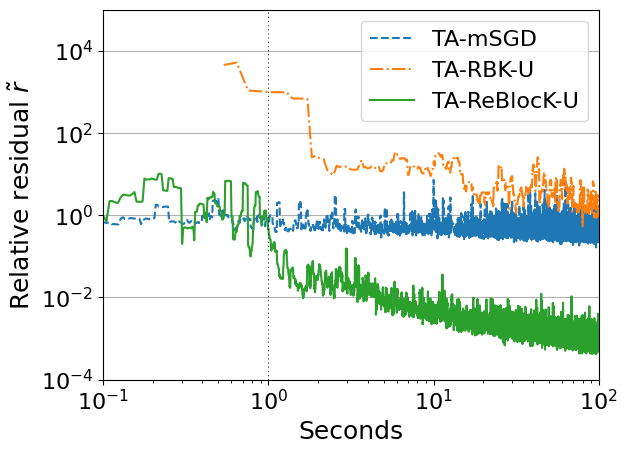

In [162]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

plt.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
plt.plot(get_ts(t_rbk), get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
plt.plot(get_ts(t_reblock), get_es(e_reblock), label='TA-ReBlocK-U')

plt.xscale('log')
plt.xlim([1e-1, 1e2])
plt.ylim([1e-4, 1e5])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Seconds')
plt.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
plt.ylabel("Relative residual $\\tilde{r}$")
plt.savefig("NN_mid.pdf", bbox_inches='tight')

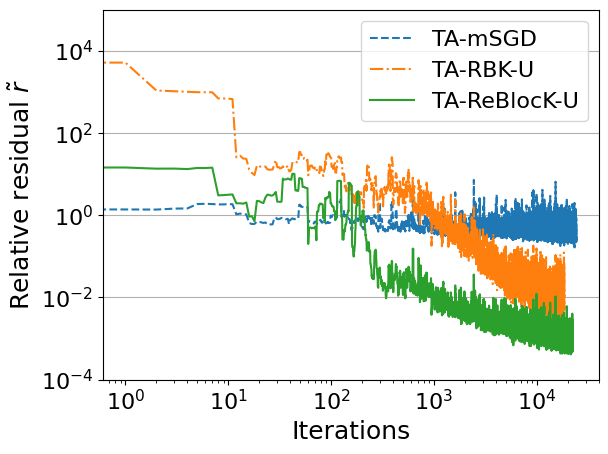

In [163]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

plt.plot(get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
plt.plot(get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
plt.plot(get_es(e_reblock), label='TA-ReBlocK-U')

plt.xscale('log')
plt.ylim([1e-4, 1e5])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel("Relative residual $\\tilde{r}$")
plt.savefig("NN_mid_it.pdf", bbox_inches='tight')

# End it k=50

In [17]:
params = end_params
t_sgd, e_sgd, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_minibatch_sgd_step(eta=1e-4))

Loss: 8.45e-01:  92%|█████████▏| 92016/100000 [01:40<00:08, 911.36it/s]


In [18]:
params = end_params
t_reblock, e_reblock, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 3.12e-02:  88%|████████▊ | 88347/100000 [01:40<00:13, 877.49it/s]


In [19]:
params = end_params
t_rbk, e_rbk, Tburn = block_kaczmarz(params, k, 20 * total_time, burn_time, get_rbk_step())

Loss: 1.15e-01: 100%|█████████▉| 1990623/2000000 [33:21<00:09, 994.69it/s]


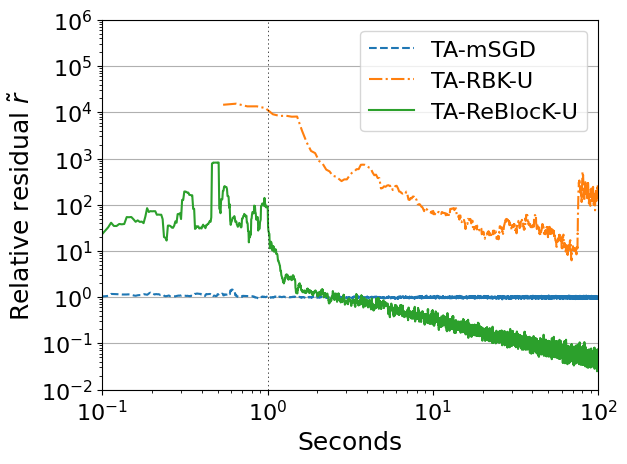

In [20]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

plt.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
plt.plot(get_ts(t_rbk), get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
plt.plot(get_ts(t_reblock), get_es(e_reblock), label='TA-ReBlocK-U')

plt.xscale('log')
plt.xlim([1e-1, 1e2])
plt.ylim([1e-2, 1e6])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Seconds')
plt.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
plt.ylabel("Relative residual $\\tilde{r}$")
plt.savefig("NN_end.pdf", bbox_inches='tight')

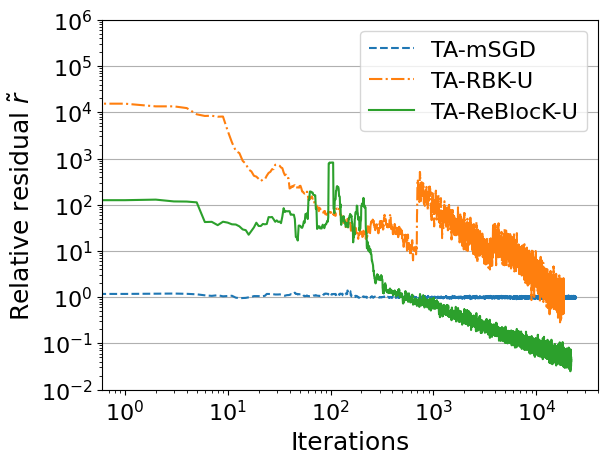

In [21]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

plt.plot(get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
plt.plot(get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
plt.plot(get_es(e_reblock), label='TA-ReBlocK-U')

plt.xscale('log')
plt.ylim([1e-2, 1e6])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel("Relative residual $\\tilde{r}$")
plt.savefig("NN_end_it.pdf", bbox_inches='tight')

# Mid it k=25

In [111]:
k=25

In [112]:
params = mid_params
t_sgd, e_sgd, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_minibatch_sgd_step(eta=1e-4))

Loss: 4.48e-01:  87%|████████▋ | 86605/100000 [01:41<00:15, 856.75it/s]


In [113]:
params = mid_params
t_reblock, e_reblock, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 1.30e-02:  83%|████████▎ | 82960/100000 [01:40<00:20, 823.99it/s]


In [114]:
params = mid_params
t_rbk, e_rbk, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_rbk_step())

Loss: 4.05e-01: : 100071it [01:40, 990.97it/s]


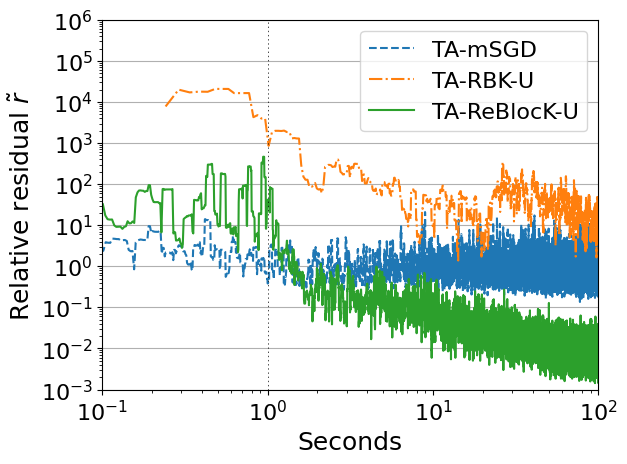

In [117]:
plt.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
plt.plot(get_ts(t_rbk), get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
plt.plot(get_ts(t_reblock), get_es(e_reblock), label='TA-ReBlocK-U')

plt.xscale('log')
plt.xlim([1e-1, 1e2])
plt.ylim([1e-3, 1e6])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Seconds')
plt.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
plt.ylabel("Relative residual $\\tilde{r}$")
plt.savefig("NN_mid_k_25.pdf", bbox_inches='tight')

# Mid it, k=100

In [118]:
k=100

In [119]:
params = mid_params
t_sgd, e_sgd, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_minibatch_sgd_step(eta=5e-5))

Loss: 3.29e-01:  91%|█████████ | 90873/100000 [01:40<00:10, 900.33it/s]


In [120]:
params = mid_params
t_reblock, e_reblock, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 1.67e-03:  95%|█████████▌| 95095/100000 [01:40<00:05, 943.39it/s]


In [121]:
params = mid_params
t_rbk, e_rbk, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_rbk_step())

Loss: 1.09e-01: : 101425it [01:41, 995.64it/s]


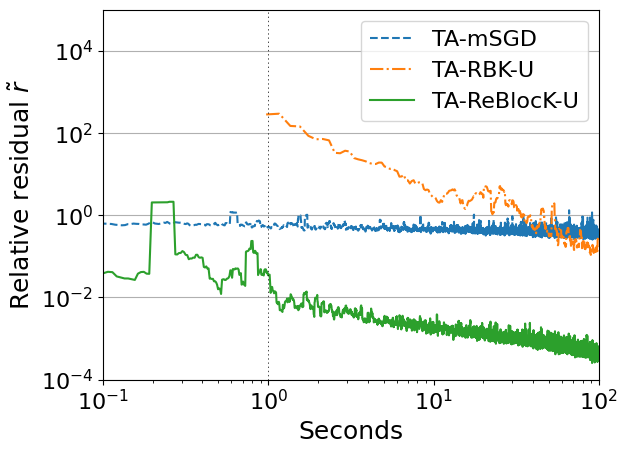

In [123]:
plt.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
plt.plot(get_ts(t_rbk), get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
plt.plot(get_ts(t_reblock), get_es(e_reblock), label='TA-ReBlocK-U')

plt.xscale('log')
plt.xlim([1e-1, 1e2])
plt.ylim([1e-4, 1e5])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Seconds')
plt.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
plt.ylabel("Relative residual $\\tilde{r}$")
plt.savefig("NN_mid_k_100.pdf", bbox_inches='tight')

# Mid it k=200

In [124]:
k = 200

In [125]:
params = mid_params
t_sgd, e_sgd, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_minibatch_sgd_step(eta=5e-5))

Loss: 3.24e-01:  97%|█████████▋| 97180/100000 [01:41<00:02, 960.17it/s]


In [126]:
params = mid_params
lamb = 1e-3
t_reblock, e_reblock, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 3.98e-04:  96%|█████████▌| 96057/100000 [01:40<00:04, 952.55it/s]


In [127]:
params = mid_params
t_rbk, e_rbk, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_rbk_step())

Loss: 2.38e-02: : 102473it [01:42, 994.92it/s]


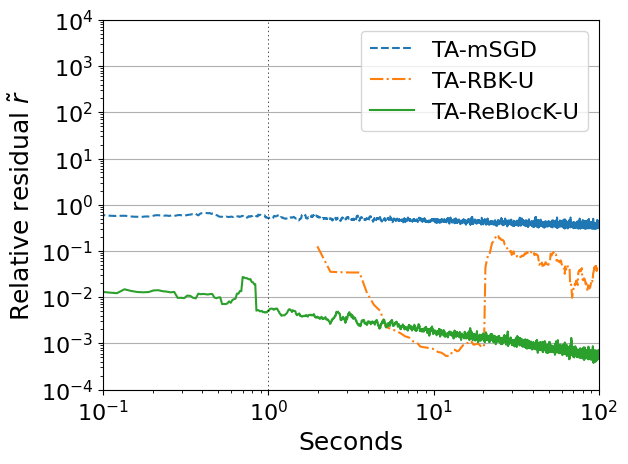

In [131]:
plt.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', linestyle='dashed')
plt.plot(get_ts(t_rbk), get_es(e_rbk), label='TA-RBK-U', linestyle='dashdot')
plt.plot(get_ts(t_reblock), get_es(e_reblock), label='TA-ReBlocK-U')

plt.xscale('log')
plt.xlim([1e-1, 1e2])
plt.ylim([1e-4, 1e4])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Seconds')
plt.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
plt.ylabel("Relative residual $\\tilde{r}$")
plt.savefig("NN_mid_k_200.pdf", bbox_inches='tight')

# Start it lambdas

In [132]:
k = 50

In [133]:
params = start_params
t_sgd, e_sgd, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_minibatch_sgd_step(eta=2e-4))

Loss: 2.52e-01:  91%|█████████▏| 91321/100000 [01:40<00:09, 907.50it/s]


In [134]:
lamb = 1
t_0, e_0, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 8.47e-02:  90%|████████▉ | 89572/100000 [01:40<00:11, 889.57it/s]


In [135]:
lamb = 1e-3
t_3, e_3, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 6.67e-02:  89%|████████▉ | 89279/100000 [01:40<00:12, 886.65it/s]


In [136]:
lamb = 1e-6
t_6, e_6, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 9.81e-02:  89%|████████▊ | 88532/100000 [01:40<00:13, 879.39it/s]


In [137]:
lamb = 1e-9
t_9, e_9, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 4.03e-01:  88%|████████▊ | 88386/100000 [01:40<00:13, 877.84it/s]


In [138]:
lamb = 1e-12
t_12, e_12, Tburn = block_kaczmarz(params, k, total_time, burn_time, get_reblock_step(lamb=lamb))

Loss: 1.76e+02:  88%|████████▊ | 88460/100000 [01:40<00:13, 878.59it/s]


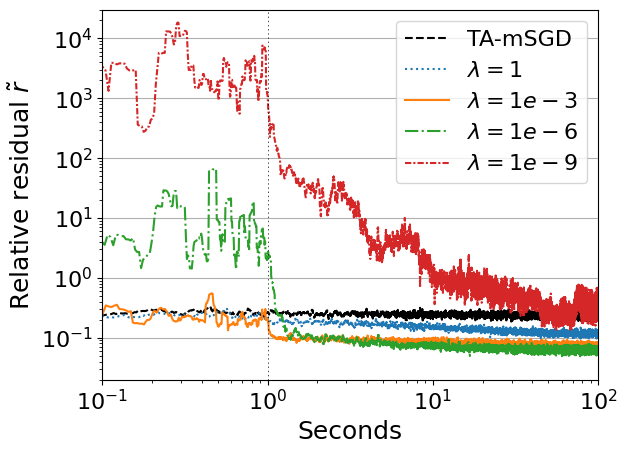

In [143]:
plt.plot(get_ts(t_sgd), get_es(e_sgd), label='TA-mSGD', color='black', linestyle='dashed')
plt.plot(get_ts(t_0), get_es(e_0), label=r'$\lambda=1$', linestyle='dotted')
plt.plot(get_ts(t_3), get_es(e_3), label=r'$\lambda=1e-3$')
plt.plot(get_ts(t_6), get_es(e_6), label=r'$\lambda=1e-6$', linestyle='dashdot')
plt.plot(get_ts(t_9), get_es(e_9), label=r'$\lambda=1e-9$', linestyle=(0, (3, 1, 1, 1)))

plt.xscale('log')
plt.xlim([1e-1, 1e2])
plt.ylim([2e-2, 3e4])
plt.yscale('log')
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.xlabel('Seconds')
plt.axvline(1.0, color='black', dashes=[2,4], linewidth=0.5)
plt.ylabel(r"Relative residual $\tilde{r}$")
plt.savefig("NN_start_lambdas.pdf", bbox_inches='tight')